### Import Statements

In [1]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectFromModel, SelectPercentile, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from mlxtend.feature_selection import ColumnSelector, SequentialFeatureSelector
import pandas as pd
import numpy as np
#from xgboost import XGBRegressor
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.tree import export_graphviz

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ecbm4040/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [3]:
data = pd.read_csv("../clean_data/FinalData_for_Models.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [5]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [6]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [7]:
data.shape

(30647, 20)

### Creating Dummies for Weather Data

In [8]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [9]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [10]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [11]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [12]:
data.shape

(30647, 24)

In [13]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [14]:
data['holiday'] = data.holiday.astype(int)

In [15]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [16]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [17]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [18]:
data.shape

(30647, 24)

### Quantile Cuts for Hour of Day to divide Hour of Days into 4 Main 6 Hour Categories

In [19]:
# outs = data['HourOfDay'] 
# data['HourOfDay'] = pd.qcut(data['HourOfDay'], 4)

In [20]:
data.dtypes

pickup_time                     object
num_pickups                    float64
num_passengers                 float64
temp                           float64
temp_min                       float64
temp_max                       float64
humidity                       float64
wind_speed                     float64
Passengers                     float64
Month                            int64
HourOfDay                        int64
DayOfWeek                        int64
holiday                          int64
precip_in                      float64
Avg_Delay_Arriving             float64
Avg_Delay_Departing            float64
Cancelled_Arriving_Flights     float64
Cancelled_Departing_Flights    float64
clear                            int64
clouds                           int64
fog                              int64
rain                             int64
snow                             int64
thunderstorm                     int64
dtype: object

In [21]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Drop the Pickup Time and Number of Passengers

In [22]:
data.drop([
        "pickup_time",
        "num_passengers"], axis=1, inplace=True)

### Dropping cancelled arriving flights as they should have no influence in pickups at LGA

In [23]:
## as they will probably have no predictive value
data.drop(['Cancelled_Arriving_Flights'], axis=1, inplace=True)

In [24]:
data.drop(['Avg_Delay_Departing'], axis=1, inplace=True)

### Last 2 hour Passengers (1 Hour Ago and 2 Hours Ago)

In [25]:
data['Prev_hour_Passengers'] = data['Passengers'].shift(1)
data['Prev_2hour_Passengers'] = data['Passengers'].shift(2)

In [26]:
data.Prev_hour_Passengers = data.Prev_hour_Passengers.fillna(method='bfill')
data.Prev_2hour_Passengers = data.Prev_2hour_Passengers.fillna(method='bfill')

### Dropping Temp_Mix and Temp_Max as we already have Temp

In [27]:
data.drop(['temp_min', 'temp_max'], axis=1, inplace=True)

### Converting Month and Day of Week to Categorical Data

In [28]:
# data.Month = pd.Categorical(data.Month)
# data.DayOfWeek = pd.Categorical(data.DayOfWeek)

In [29]:
data = pd.get_dummies(data)

In [30]:
data.head()

,num_pickups,temp,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers
0,107.0,269.27,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
1,34.0,268.90,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
2,34.0,268.48,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0
3,12.0,268.33,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0
4,25.0,268.10,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0


In [31]:
#data

In [32]:
data.dtypes

num_pickups                    float64
temp                           float64
humidity                       float64
wind_speed                     float64
Passengers                     float64
Month                            int64
HourOfDay                        int64
DayOfWeek                        int64
holiday                          int64
precip_in                      float64
Avg_Delay_Arriving             float64
Cancelled_Departing_Flights    float64
clear                            int64
clouds                           int64
fog                              int64
rain                             int64
snow                             int64
thunderstorm                     int64
Prev_hour_Passengers           float64
Prev_2hour_Passengers          float64
dtype: object

## MODELS FOLLOW FROM HERE

In [33]:
## the labels (num_pickups)
num_pickups = data.num_pickups
data.drop("num_pickups", axis=1, inplace=True)

In [34]:
data.head()

,temp,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers
0,269.27,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
1,268.90,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
2,268.48,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0
3,268.33,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0
4,268.10,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, num_pickups, random_state=0, test_size=0.15)

### VIsualizing mutual_info

In [36]:
categorical_cols = X_train.select_dtypes(include=['int64', 'uint8'])
continuous_cols = X_train.select_dtypes(exclude=['int64', 'uint8'])

In [37]:
def plot_mutual_info(data, columns):
    inds = np.argsort(data)
    plt.figure(figsize = (10,15))
    plt.barh(np.arange(len(data)), np.log(np.array(data)[inds] + 1))
    plt.yticks(np.arange(len(data)), np.array(columns)[inds])
    plt.ylim(0, len(data))
    plt.xlabel('Mutual Information')

In [38]:
mi_continuous = mutual_info_regression(continuous_cols, y_train, discrete_features=False, n_neighbors = 3, 
                                    random_state=42)


mi_categorical = mutual_info_regression(categorical_cols, y_train, discrete_features=True, n_neighbors = 3, 
                                     random_state=42)

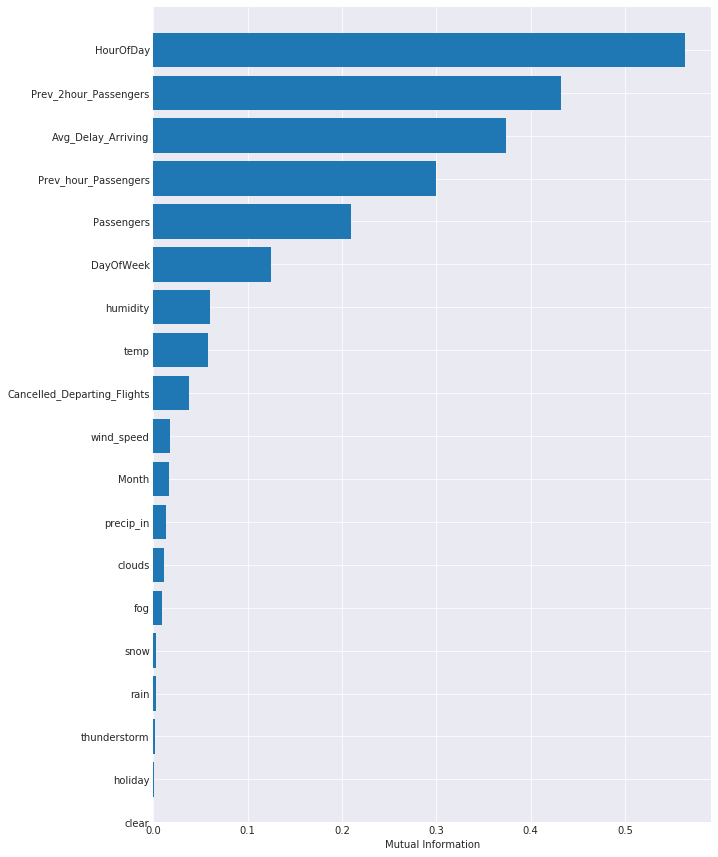

In [39]:
mutual_info = mi_continuous.tolist() + mi_categorical.tolist()
mutual_info_columns = continuous_cols.columns.tolist() + categorical_cols.columns.tolist()
plot_mutual_info(mutual_info, mutual_info_columns)

In [40]:
data.head()

,temp,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers
0,269.27,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
1,268.90,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
2,268.48,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0
3,268.33,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0
4,268.10,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0


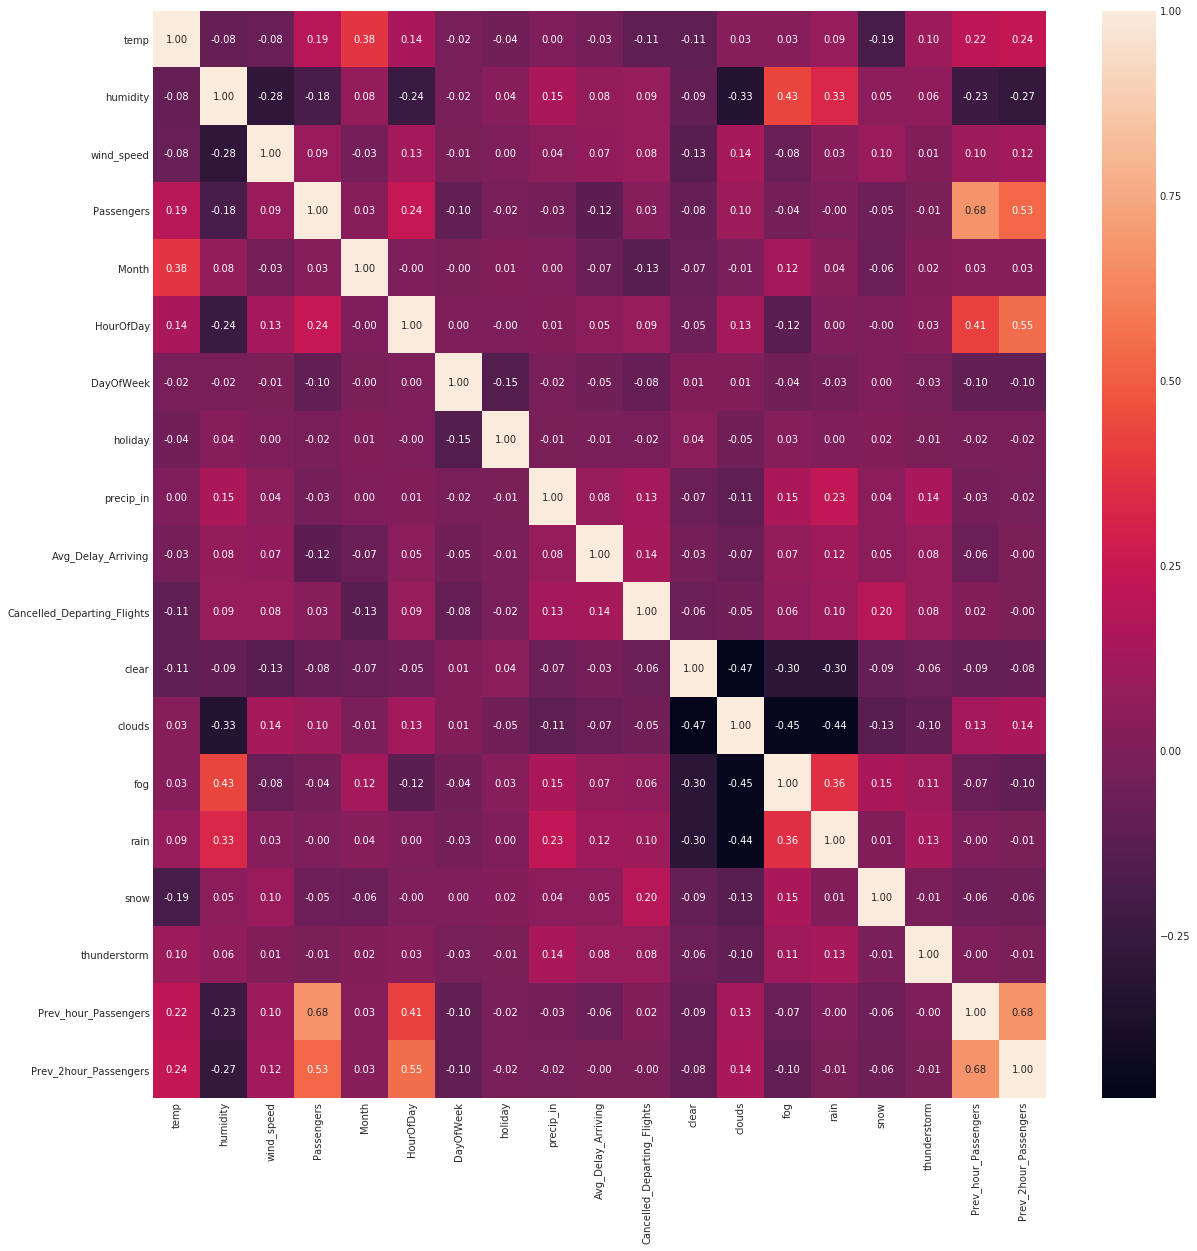

In [41]:
cor_scaler = StandardScaler()
data_scaled = cor_scaler.fit_transform(data)
plt.figure(figsize=(20,20))
sns.heatmap(pd.DataFrame(data_scaled, columns=data.columns).corr(),
           annot=True, fmt=".2f")

### Some functions

In [42]:
def get_predictions(X_train, y_train, X_test, classifier):
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    return classifier.predict(X_test)

In [43]:
def plot_errors_hour(data, predictions, y_test):
    test_hours = data['HourOfDay'].loc[y_test.index]
    errors_df = pd.DataFrame({'HourOfDay' : test_hours, 'y_test' : y_test, 'predictions' : predictions})
    errors_df['error'] = errors_df.predictions - errors_df.y_test
    errors_df['error frac'] = errors_df.error / errors_df.y_test
    errors_df_hourly = errors_df.groupby('HourOfDay').agg({'error' : 'mean', 'error frac' : 'mean'})
    errors_df_hourly.plot(kind = 'bar')
    return errors_df_hourly

## Model_Ridge : Ridge Regression

In [44]:
select_lassocv = SelectFromModel(LassoCV(max_iter=1500), threshold="median")
ridge_pipe = make_pipeline(StandardScaler(), select_lassocv, PolynomialFeatures(interaction_only=True),
                           VarianceThreshold(), Ridge())
ridge_params = {'ridge__alpha' : [0.01, 0.1, 1.0, 10.0, 100.0, np.log(14)],
                'polynomialfeatures__degree' : [2]}

In [45]:
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [46]:
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfe

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    7.7s remaining:    7.7s


[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=   3.7s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   3.6s
[CV] .. polynomialfeatures__degree=2, ridge__alpha=10.0, total=   5.1s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   3.2s
[CV] ... polynomialfeatures__degree=2, ridge__alpha=1.0, total=   6.9s
[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=   4.4s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   3.7s
[CV] .. polynomialfeatures__degree=2, ridge__alpha=10.0, total=   6.0s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   3.7s
[CV] .. polynomialfeatures__degree=2, ridge__alpha=10.0, total=   5.3s
[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=   4.9s
[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=   4.9s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   4.0s
[CV] . polynomialfeatures__degree=2, ridge

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1500, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='aut...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 2.6390573296152584], 'polynomialfeatures__degree': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [47]:
ridge_grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10.0}

In [48]:
ridge_grid.best_score_

0.72815789646524909

In [49]:
ridge_grid.score(X_test, y_test)

0.72691229434708193

In [50]:
joblib.dump(ridge_grid.best_estimator_, "gridSearch_DTC/model_ridge.pkl")

['gridSearch_DTC/model_ridge.pkl']

### Random Forest

In [51]:
rf_pipe = make_pipeline(RandomForestRegressor(n_jobs=-1))
rf_params = {'randomforestregressor__n_estimators' : [50, 100, 200], 
             'randomforestregressor__max_features' : ["auto", "sqrt", "log2"],
             'randomforestregressor__max_depth' : [5, 9, 11, 15, 17, 21],
#              'randomforestregressor__criterion' : ['mae', 'mse'],
             'randomforestregressor__warm_start' : [True, False]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [52]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50,

[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   3.6s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   3.7s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   3.6s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomfores

[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   8.7s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=   7.8s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   8.1s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomfores

[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   1.4s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   2.6s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__

[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=   3.1s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   3.2s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor_

[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   8.1s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   8.6s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__w

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   27.6s


[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   3.0s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   3.3s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   3.2s
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomfore

[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  15.8s
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  16.0s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   6.4s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomfor

[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   1.7s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   2.1s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__

[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   6.2s
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   5.1s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   5.8s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomfor

[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   5.2s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   5.6s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   5.2s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, rand

[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   2.2s
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   2.0s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   2.1s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, rando

[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   2.4s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   2.8s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=   5.3s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, ra

[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   5.1s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=  14.3s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   5.3s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomfo

[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   7.1s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   6.6s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   7.1s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, random

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  1.7min


[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=  26.9s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   4.2s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=  12.1s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, random

[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   3.5s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   3.7s
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   3.5s
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, ran

[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=  10.8s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=  10.7s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__

[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   7.1s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   7.3s
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   7.7s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, ra

[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  29.8s
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  29.0s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregr

[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   8.8s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   8.1s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregres

[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   6.5s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=  18.1s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregresso

[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=  27.3s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   8.8s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor

[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  34.4s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  10.7s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestre

[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestregressor__n_estimators': [50, 100, 200], 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [5, 9, 11, 15, 17, 21], 'randomforestregressor__warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [53]:
rf_grid.best_score_

0.89407067442651489

In [54]:
rf_grid.best_params_

{'randomforestregressor__max_depth': 21,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 200,
 'randomforestregressor__warm_start': True}

In [55]:
rf_grid.score(X_test, y_test)

0.89994876737487151

In [56]:
joblib.dump(rf_grid.best_estimator_, "gridSearch_DTC/model_rf.pkl")

['gridSearch_DTC/model_rf.pkl']

### Gradient Boosting Regressor

In [57]:
gbt_pipe = make_pipeline(GradientBoostingRegressor(random_state=0, learning_rate=0.1))
gbt_params = {'gradientboostingregressor__n_estimators' : [50, 100, 200, 250],
              'gradientboostingregressor__max_features' : ["auto", "sqrt", "log2"],
              'gradientboostingregressor__max_depth' : [3, 5, 10, 15],
              'gradientboostingregressor__warm_start' : [False, True],
             }

gbt_grid = GridSearchCV(gbt_pipe, gbt_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [58]:
gbt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_de

[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   2.2s
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   2.1s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total=   2.0s
[CV] gradientboostingregressor__max_depth=3, gradien

[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   0.9s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   0.9s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregres

[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=   1.7s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=   1.9s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregres

[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   0.5s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   0.5s
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   0.5s
[CV] gradientboostingregressor__max_depth=3, gradientboos

[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=   2.2s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=   1.7s
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=   1.7s
[CV] gradientboostingregressor__max_depth=5, gradient

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   12.9s


[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   4.1s
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   4.2s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   4.1s
[CV] gradientboostingregressor__max_depth=5, gradientb

[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.1s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.1s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.1s
[CV] gradientboostingregressor__max_depth=5, gradientboos

[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total=  13.0s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total=  13.0s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor

[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.1s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=   4.9s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   1.1s
[CV]  gradientboostingregressor__max_depth=5, gradien

[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   2.2s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total=   2.1s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=  16.8s
[CV] gradientboostingregressor__max_depth=5, gradien

[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=   4.6s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=   4.8s
[CV] gradientboostingregressor__max_depth=10, gradientboostingr

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=  50.2s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total=  49.7s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total=  50.0s
[CV] gradientboostingregressor__max_depth=10, gra

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=  14.0s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total=   8.0s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total= 1.4min
[CV] gradientboostingregressor__max_depth=10, gr

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 1.5min
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total=  16.7s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total=  25.5s
[CV] gradientboostingregressor__max_depth=10, grad

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.0min


[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   8.0s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   8.6s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=  30.9s
[CV] gradientboostingregressor__max_depth=10, g

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total= 1.8min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total=  16.6s
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total= 1.9min
[CV] gradientboostingregressor__max_depth=15, gradi

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total= 2.0min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total= 2.1min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total= 2.8min
[CV] gradientboostingregressor__max_depth=15, grad

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total= 4.0min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=  39.8s
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=  40.7s
[CV] gradientboostingregressor__max_depth=15, gradie

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 6.1min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total= 1.1min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total= 1.2min
[CV] gradientboostingregressor__max_depth=15, gr

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total= 7.4min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total= 7.6min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total= 7.6min
[CV] gradientboostingregressor__max_depth=15,

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total= 7.4min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total= 2.7min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total= 1.2min
[CV] gradientboostingregressor__max_depth=15, gr

[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 17.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min...ors=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gradientboostingregressor__n_estimators': [50, 100, 200, 250], 'gradientboostingregressor__max_features': ['auto', 'sqrt', 'log2'], 'gradientboostingregressor__max_depth': [3, 5, 10, 15], 'gradientboostingregressor__warm_start': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [59]:
gbt_grid.best_params_

{'gradientboostingregressor__max_depth': 10,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 200,
 'gradientboostingregressor__warm_start': False}

In [60]:
gbt_grid.best_score_

0.89765923544517501

In [61]:
gbt_grid.score(X_test, y_test)

0.90398295135241091

In [62]:
joblib.dump(gbt_grid.best_estimator_, "gridSearch_DTC/model_gbt.pkl")

['gridSearch_DTC/model_gbt.pkl']

## XGBoost Regressor

In [63]:
n_estimators = [50, 100, 200, 250]
max_depth = [3, 6, 8]
learning_rate = [0.1, 0.3]
subsample = [1.0]
colsample_bytree = [0.7]
colsample_bylevel = [0.6]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
param_grid = dict(xgbregressor__n_estimators=n_estimators, 
                  xgbregressor__max_depth=max_depth, 
                  xgbregressor__learning_rate=learning_rate, 
                  xgbregressor__subsample=subsample, 
                  xgbregressor__colsample_bytree=colsample_bytree, 
                  xgbregressor__colsample_bylevel=colsample_bylevel,
                  xgbregressor__gamma=gamma
                 )
xgb_pipe = make_pipeline(StandardScaler(), XGBRegressor())
xgb_grid = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=5, scoring='r2', verbose=2)

In [64]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregres

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 13.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgbregressor__n_estimators': [50, 100, 200, 250], 'xgbregressor__max_depth': [3, 6, 8], 'xgbregressor__learning_rate': [0.1, 0.3], 'xgbregressor__subsample': [1.0], 'xgbregressor__colsample_bytree': [0.7], 'xgbregressor__colsample_bylevel': [0.6], 'xgbregressor__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verb

In [65]:
xgb_grid.best_score_

0.9000361352223436

In [66]:
xgb_grid.best_params_

{'xgbregressor__colsample_bylevel': 0.6,
 'xgbregressor__colsample_bytree': 0.7,
 'xgbregressor__gamma': 0.1,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 250,
 'xgbregressor__subsample': 1.0}

In [67]:
xgb_grid.score(X_test, y_test)

0.9040792272805136

In [68]:
joblib.dump(xgb_grid.best_estimator_, "gridSearch_DTC/model_xgb.pkl")

['gridSearch_DTC/model_xgb.pkl']

### MLXTEND

In [73]:
from mlxtend.regressor import StackingCVRegressor

In [74]:
select_lassocv = SelectFromModel(LassoCV(max_iter=1500), threshold="median")

rf_mlxtend = RandomForestRegressor(max_depth=21, 
                                   max_features='auto', 
                                   n_estimators=200, 
                                   warm_start=True)

ridge_pipe = make_pipeline(StandardScaler(), select_lassocv, PolynomialFeatures(interaction_only=True),
                           VarianceThreshold(), Ridge(alpha=10.0))

gbt_mlxtend = GradientBoostingRegressor(max_depth=10, 
                                        max_features='auto', 
                                        n_estimators=200, 
                                        warm_start=False)

xgb_mlxtend = make_pipeline(StandardScaler(), XGBRegressor(colsample_bylevel=0.6,
                                                          colsample_bytree=0.7,
                                                          gamma=0.1,
                                                          learning_rate=0.1,
                                                          max_depth=8,
                                                          n_estimators=250,
                                                          subsample=1.0))

RANDOM_SEED = 10

### Stacking Regressor 1

In [75]:
# DONT USE N_JOBS = -1 FOR STACKINGCVCLASSIFIER, IT HANGS

np.random.seed(RANDOM_SEED)
stack = StackingCVRegressor(regressors=(rf_mlxtend, gbt_mlxtend, xgb_mlxtend), meta_regressor=ridge_pipe)

grid_stack1 = GridSearchCV(
    estimator=stack, 
    param_grid={}, 
    cv=5,
    verbose=3, 
    scoring="r2", 
    refit=True
)


In [76]:
grid_stack1.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.9036819337684967, total= 6.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s


[CV] ....................... , score=0.9063209335292837, total= 6.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.4min remaining:    0.0s


[CV] ........................ , score=0.900578115888119, total= 6.2min
[CV]  ................................................................
[CV] ....................... , score=0.9039125907551527, total= 6.2min
[CV]  ................................................................
[CV] ....................... , score=0.9020076052309295, total= 6.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 31.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=StackingCVRegressor(cv=5,
          meta_regressor=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max...1, seed=0, silent=True, subsample=1.0))])),
          shuffle=True, use_features_in_secondary=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [77]:
grid_stack1.best_score_

0.90330028545743757

In [78]:
grid_stack1.score(X_test, y_test)

0.90767463399635717

In [79]:
joblib.dump(grid_stack1.best_estimator_, "gridSearch_DTC/model_rfgbtxgb_rd.pkl")

['gridSearch_DTC/model_rfgbtxgb_rd.pkl']

In [81]:
# load the model from disk
loaded_model = joblib.load("gridSearch_DTC/model_rfgbtxgb_rd.pkl")
result = loaded_model.score(X_test, y_test)
print(result)

0.907674633996


### Stacking Regressor 2

In [83]:
np.random.seed(RANDOM_SEED)
stack = StackingCVRegressor(regressors=(rf_mlxtend, gbt_mlxtend, xgb_mlxtend), meta_regressor=LassoCV(max_iter=2000))

grid_stack1 = GridSearchCV(
    estimator=stack, 
    param_grid={}, 
    cv=5,
    verbose=3, 
    scoring="r2", 
    refit=True
)

In [84]:
grid_stack1.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.9038405675821971, total= 6.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s


[CV] ....................... , score=0.9064041811729198, total= 6.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.4min remaining:    0.0s


[CV] ....................... , score=0.9003925908053396, total= 6.2min
[CV]  ................................................................
[CV] ....................... , score=0.9041978508751719, total= 6.2min
[CV]  ................................................................
[CV] ....................... , score=0.9018985317885488, total= 6.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 31.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=StackingCVRegressor(cv=5,
          meta_regressor=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=2000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=Fal...1, seed=0, silent=True, subsample=1.0))])),
          shuffle=True, use_features_in_secondary=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [85]:
grid_stack1.best_score_

0.90334680004054579

In [86]:
grid_stack1.score(X_test, y_test)

0.90815968684213499

In [87]:
joblib.dump(grid_stack1.best_estimator_, "gridSearch_DTC/model_rfgbtxgb_la.pkl")

['gridSearch_DTC/model_rfgbtxgb_la.pkl']

In [88]:
# load the model from disk
loaded_model = joblib.load("gridSearch_DTC/model_rfgbtxgb_la.pkl")
result = loaded_model.score(X_test, y_test)
print(result)

0.908159686842


In [91]:
loaded_model

StackingCVRegressor(cv=5,
          meta_regressor=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=2000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
          regressors=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimato...near', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1.0))])),
          shuffle=True, use_features_in_secondary=False)

In [92]:
loaded_model.meta_regr_.coef_

array([ 0.18910601,  0.31406245,  0.50611007])

In [93]:
loaded_preds = loaded_model.predict(X_test)

In [94]:
data.head()

,temp,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers
0,269.27,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
1,268.90,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0
2,268.48,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0
3,268.33,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0
4,268.10,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0


In [96]:
results = pd.DataFrame({'Hour': X_test.loc[y_test.index, "HourOfDay"], 'Predictions': loaded_preds, 'Actual': y_test})

In [97]:
results_grouped = results.groupby('Hour').mean()
results_grouped

,Actual,Predictions
Hour,,
0,258.390476,244.337861
1,59.331551,50.358277
2,13.411765,8.752893
3,4.921875,3.305248
4,7.189944,3.253951
5,13.640212,9.600469
6,28.868132,26.478055
7,190.661082,191.936497
8,326.583732,332.454906


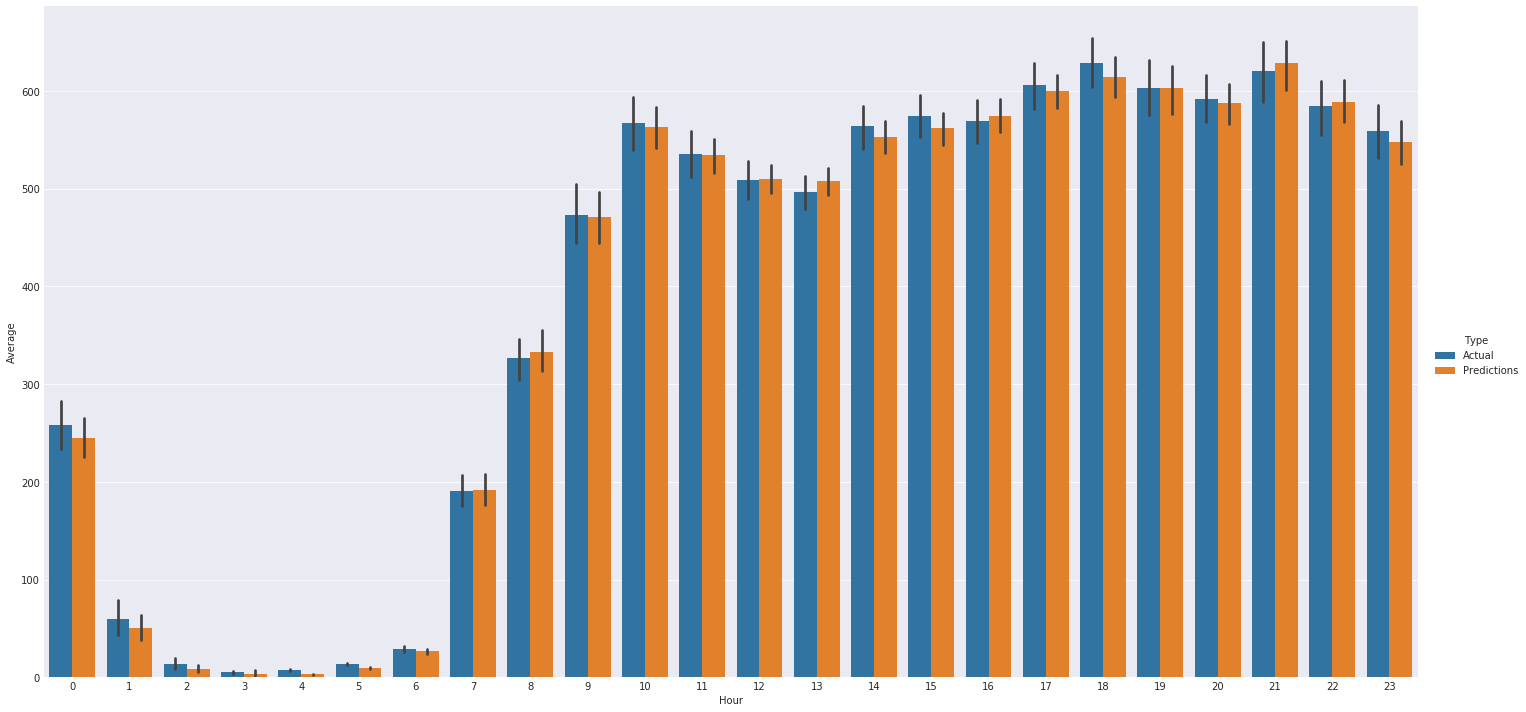

In [98]:
results_melted = pd.melt(results, id_vars="Hour", var_name="Type", value_name="Average")
sns.factorplot(x='Hour', y='Average', hue='Type', data=results_melted, kind='bar', size=10, aspect = 2)